# (10) mnist — tst

**Motivation**: host = ```any```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [3]:
model_name = 'poisson_uniform_c(-2)_MNIST_t-10_z-[128]_k-32_<jacob|mlp+b>'
# fit_1 = 'warm1_clamp-state-5.3-du-6_anneal-0.3_b200-ep500-lr(0.002)_beta(5:0x0.3)_temp(0.05:lin-0.5)_gr(100)_(2024_09_10,10:45)'
# fit_2 = 'warm1_clamp-state-5.3-du-6_b200-ep500-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(100)_(2024_09_10,10:44)'
# fit_3 = 'warm1_clamp-state-5.3-du-10_b600-ep1500-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(100)_(2024_09_10,09:46)'
fit_name = 'warm1_clamp-state:Upper(6.5)-du:Upper(10.0)_b200-ep500-lr(0.002)_beta(5:0x0.3)_temp(0.05:lin-0.5)_gr(100)_(2024_09_10,14:12)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

450

In [4]:
print(tr.model.layer.n_exp)

tensor([14, 22, 31, 36, 40, 42, 43, 44, 45, 45], device='cuda:0',
       dtype=torch.int32)

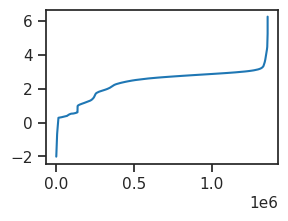

In [5]:
plt.plot(sorted(tr.model.stats['u_max']))

In [7]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

u_max[u_max > 10], du_max[du_max > 10]

(array([], dtype=float64), array([], dtype=float64))

In [8]:
(u_max > 10).sum()

0

In [9]:
u_max.max()

6.251061916351318

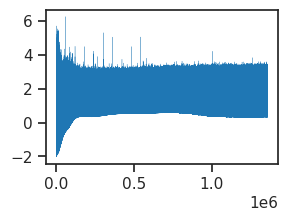

In [10]:
plt.plot(u_max, lw=0.2)

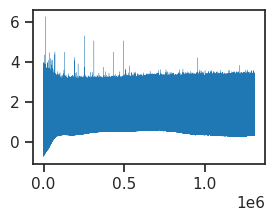

In [11]:
plt.plot(u_max[50000:], lw=0.2)

In [12]:
tmp = u_max[50000:].copy()
(tmp > 4.5).sum() / len(tmp)

2.517162471395881e-05

In [13]:
(u_max > 4.0).sum() / len(u_max)

0.007113886847905952

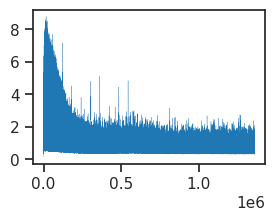

In [14]:
plt.plot(du_max, lw=0.2)

In [15]:
du_max.max()

8.788373947143555

In [16]:
(du_max > 8).sum() / len(du_max)

4.40852314474651e-05

In [17]:
(du_max > 6).sum() / len(du_max)

0.002567229977957384

In [19]:
print({
    k: pois.n_exp for k, pois
    in output['dist'].items()
})
print('mean = ', np.mean([
    pois.n_exp for k, pois in
    output['dist'].items()
]))

{'0': 14, '1': 22, '2': 31, '3': 36, '4': 40, '5': 42, '6': 43, '7': 44, '8': 45, '9': 45}

mean =  36.2

In [21]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in tqdm(iter(tr.dl_vld)):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}

100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 25.61it/s]


In [22]:
pal = sns.cubehelix_palette(
    n_colors=tr.model.cfg.seq_len,
    start=2.5,
    rot=0.3,
    gamma=1.0,
    hue=0.9,
    light=0.85,
    dark=0.15,
    reverse=False,
    as_cmap=False,
)
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.8178323483750889, 0.7228373334284097, 0.9156857084467959],
 [0.7243842279061081, 0.6447757533596252, 0.8762257510361532],
 [0.621433610824204, 0.5738491579616475, 0.8244120665462615],
 [0.5137602016853071, 0.5080741960907603, 0.7578471038208457],
 [0.41165859076399486, 0.44819771588937396, 0.6800995692970601],
 [0.3090934491249027, 0.3854178083786437, 0.5835384610223103],
 [0.2159918198929715, 0.32026582325789205, 0.4738907509899629],
 [0.13614552585465997, 0.2501791993868458, 0.35455980691569594],
 [0.07235872150128392, 0.17287618251766537, 0.23013648857700542]]

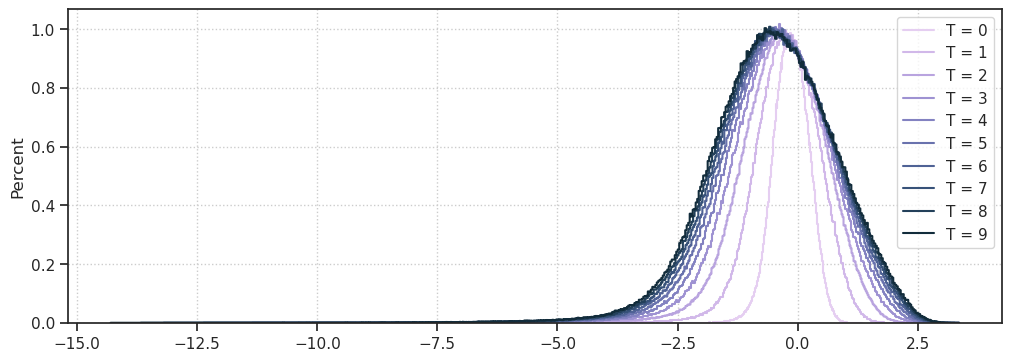

In [23]:
fig, ax = create_figure(1, 1, (10, 3.5))
for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v.ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
ax.legend()
ax.grid()
plt.show()

In [24]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    # active=~dead,
    # full_data=True,
    # return_recon=True,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn', 'tst']
}

100%|█████████████████████████████████| 50/50 [04:25<00:00,  5.31s/it]


CPU times: user 4min 22s, sys: 3.93 s, total: 4min 26s
Wall time: 4min 27s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

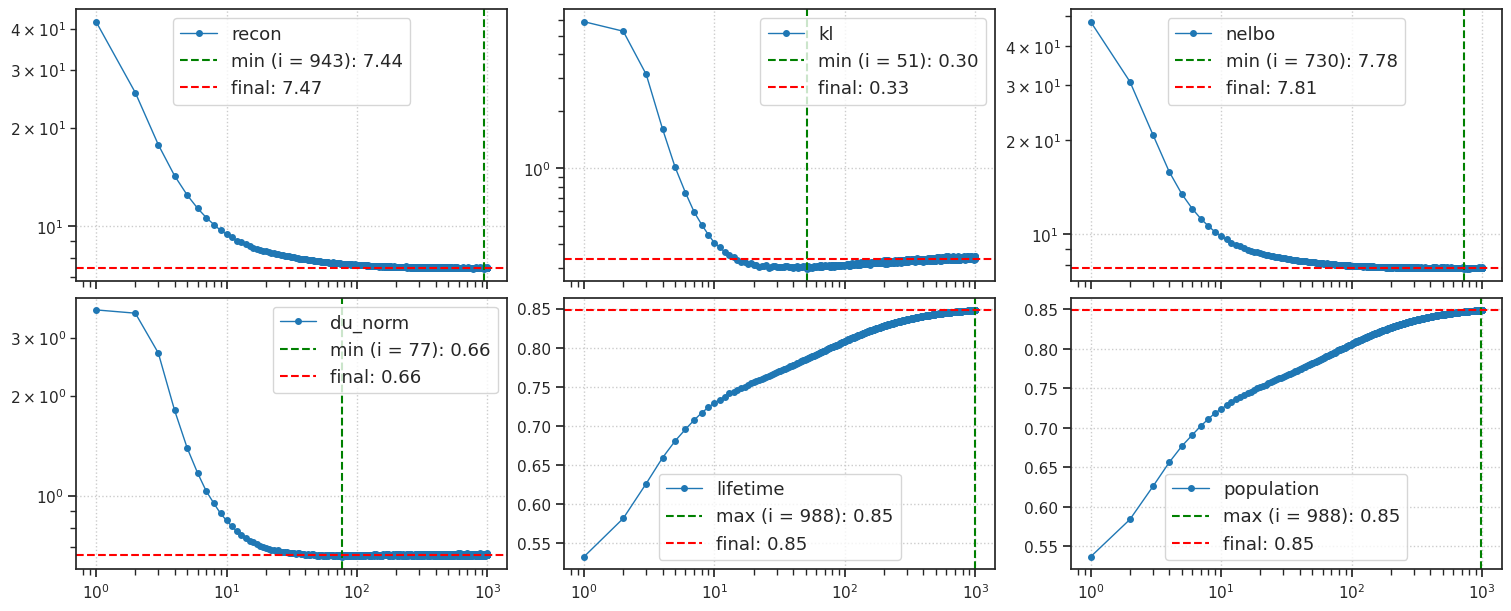

In [25]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

In [23]:
print({
    np.round(x, 3): np.exp(x) for x
    in np.linspace(5.0, 8.0, 31)
})

{
    5.0: 148.4131591025766,
    5.1: 164.02190729990167,
    5.2: 181.27224187515122,
    5.3: 200.33680997479163,
    5.4: 221.40641620418717,
    5.5: 244.69193226422038,
    5.6: 270.42640742615254,
    5.7: 298.8674009670603,
    5.8: 330.2995599096486,
    5.9: 365.03746786532895,
    6.0: 403.4287934927351,
    6.1: 445.85777008251677,
    6.2: 492.7490410932564,
    6.3: 544.5719101259289,
    6.4: 601.8450378720822,
    6.5: 665.1416330443618,
    6.6: 735.0951892419727,
    6.7: 812.4058251675432,
    6.8: 897.8472916504176,
    6.9: 992.2747156050262,
    7.0: 1096.6331584284585,
    7.1: 1211.9670744925763,
    7.2: 1339.430764394418,
    7.3: 1480.2999275845464,
    7.4: 1635.984429995927,
    7.5: 1808.0424144560632,
    7.6: 1998.1958951041174,
    7.7: 2208.3479918872085,
    7.8: 2440.6019776245007,
    7.9: 2697.28232826851,
    8.0: 2980.9579870417283
}

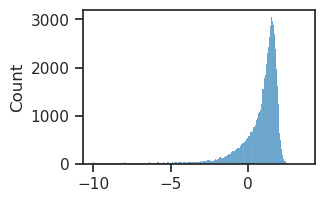

In [29]:
x2p = results['vld']['state_final'].ravel()
x2p = x2p[x2p > -10]
sns.histplot(x2p);

<Axes: ylabel='Count'>

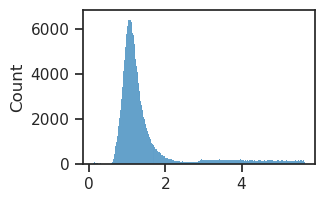

In [28]:
sns.histplot(tr.model.stats['du_max'])

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

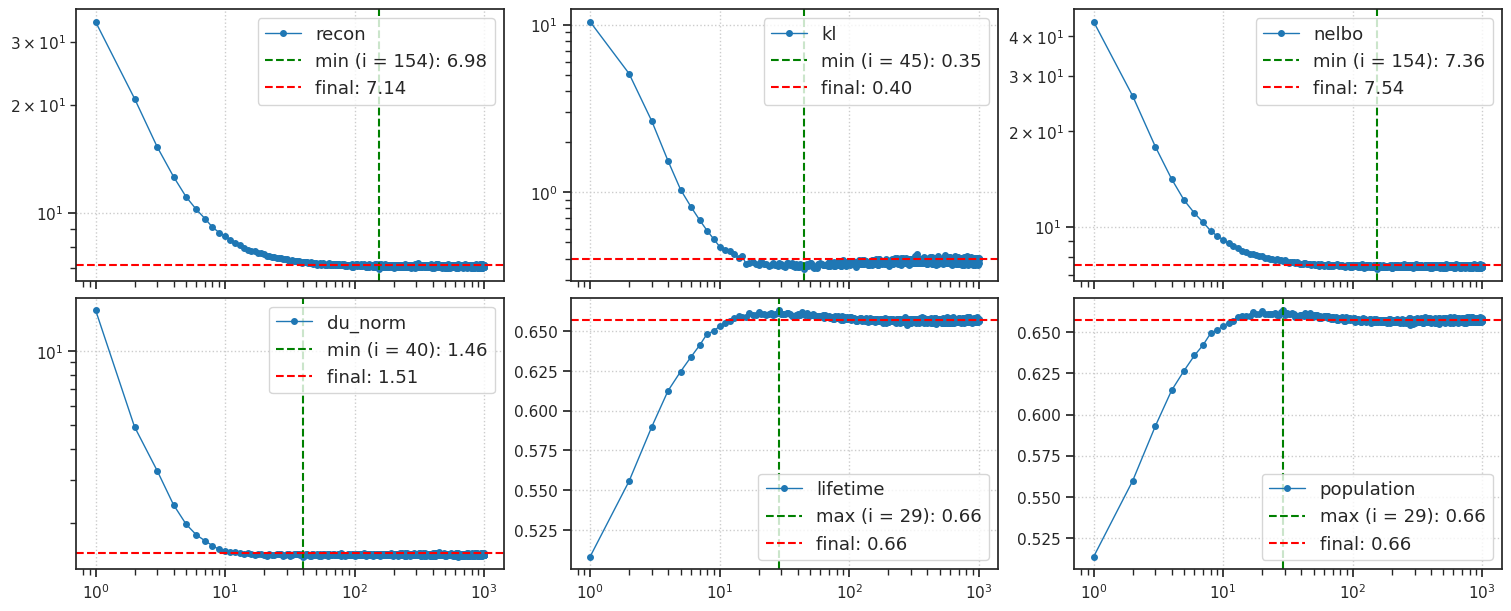

In [9]:
## was clamp = 12.0

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

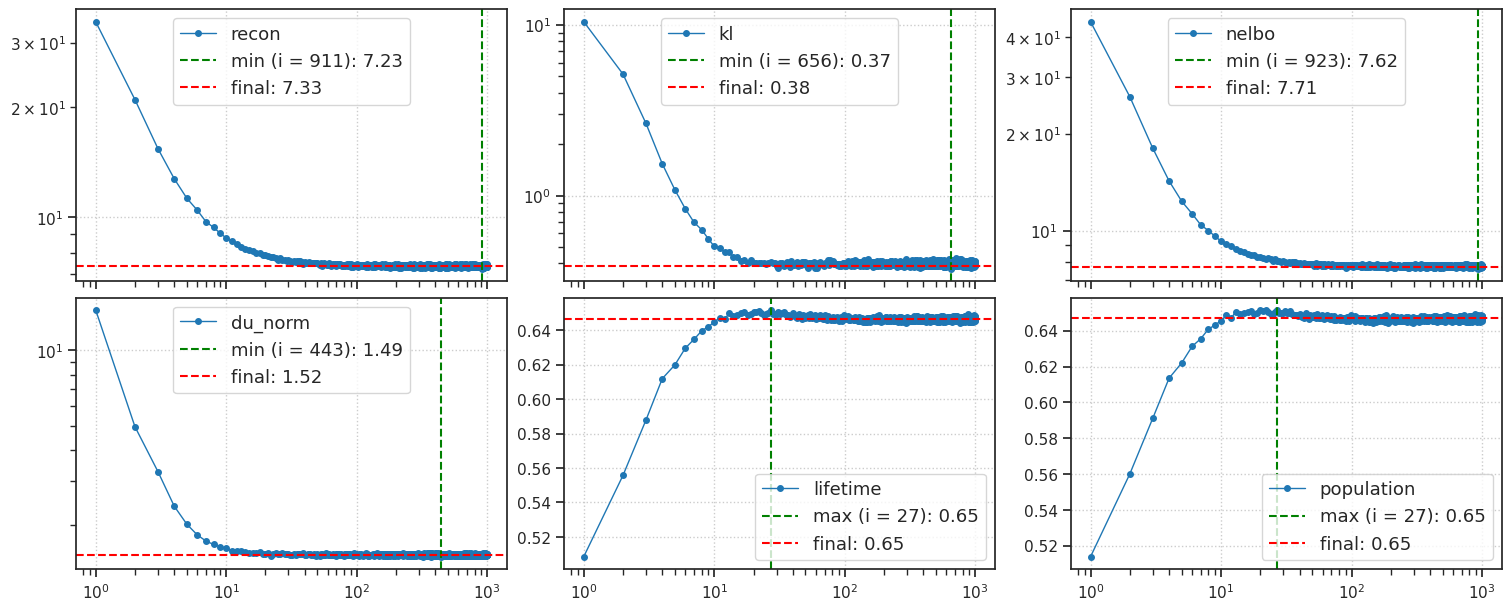

In [9]:
## was clamp = 8.0

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

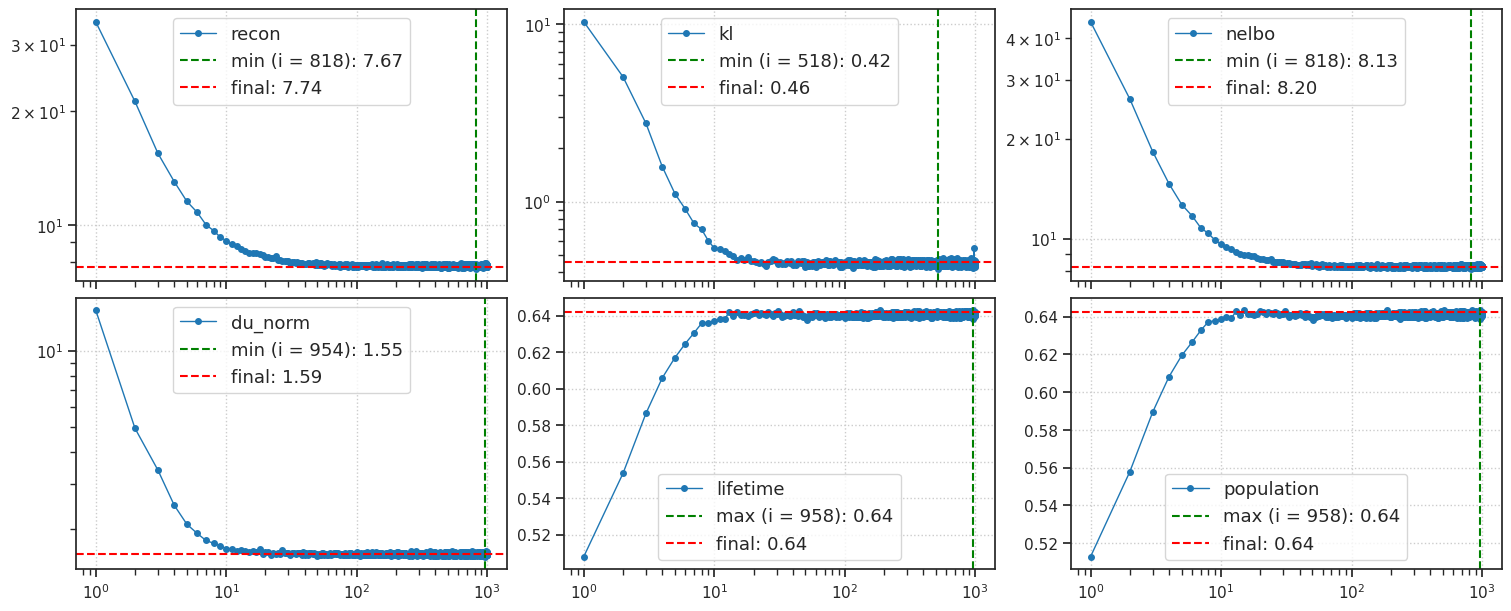

In [9]:
## was clamp = 6.0

In [12]:
list(results['vld']['state_final'])

['kl',
 'recon',
 'nelbo',
 'du_norm',
 'lifetime',
 'population',
 'state_final',
 'samples_final']

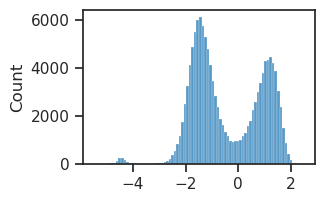

In [16]:
tr.model.layer.get_clamp(2.0, 6.0)

tensor(6., device='cuda:0')

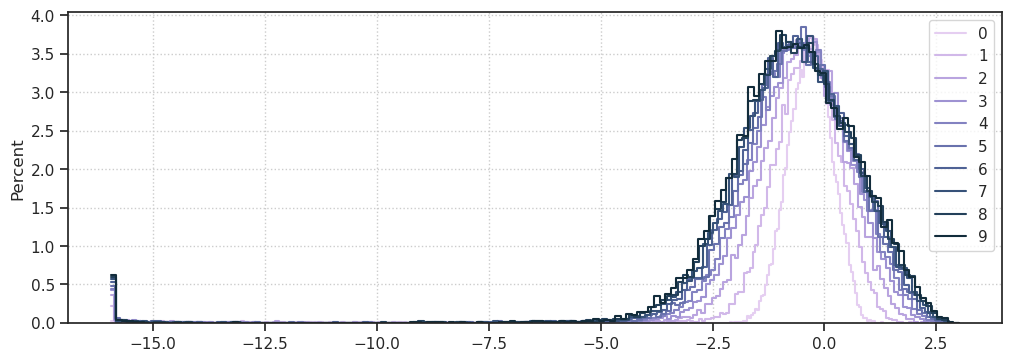

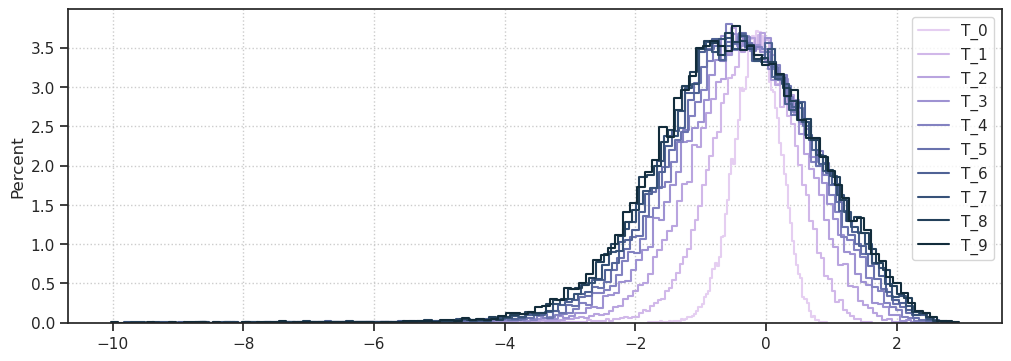

In [8]:
pois = output['dist']['9']
print(pois.n_exp)

47

In [10]:
# tot = 0
# for i, m in pois.masks.items():
#     tot += m.sum() * pois.n_exp[i]

# print(tot)

In [12]:
# total_full = pois.rate.numel() * list(pois.n_exp.values())[-1]
# total_full

In [ ]:
from torchvision.transforms.functional import rotate
train_zs, train_targets, val_zs, val_targets = [], [], [], []
    for batch in train_dl_digit:
        batch[0] = rotate(batch[0].reshape(-1, 28, 28), angle).reshape(-1, 784)
        with torch.no_grad():
            tracker = model.model.forward_dict(batch[0].cuda())
        train_zs.append(torch.stack(tracker["zs"], 1))
        train_targets.append(batch[1])

In [13]:
print(tot / total_full)

tensor(0.2867, device='cuda:0')

In [14]:
%timeit pois.rsample()

1.27 ms ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
from base.distributions import PoissonOld

In [16]:
pois_old = PoissonOld(torch.log(pois.rate), pois.t)

In [17]:
%timeit pois_old.rsample()

137 µs ± 507 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
self = pois

In [15]:
for i, m in self.masks.items():
    self.rate[m]

<Axes: ylabel='Count'>

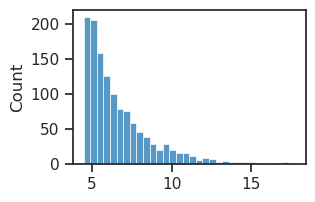

In [17]:
sns.histplot(tonp(self.rate[m]))

In [24]:


exp = dists.Exponential(self.rate[m])
x = exp.rsample((self.n_exp[i],))
times = torch.cumsum(x, dim=0)

indicator = times < 1.0
z_hard = indicator.sum(0).float()

if self.t > 0:
    indicator = torch.sigmoid(
        (1.0 - times) / self.t)
    z = indicator.sum(0).float()
else:
    z = z_hard

if hard:
    return z + (z_hard - z).detach()
return z

In [25]:
times.shape

torch.Size([41, 1280])

In [32]:
z = _rsample_per_group(self, self.rate[m], )

<Axes: ylabel='Count'>

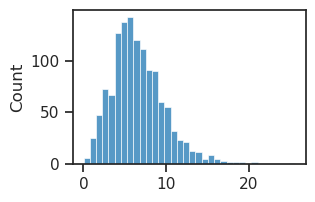

In [34]:
sns.histplot(tonp(z).ravel())

In [8]:
pois = output['dist']['T_9']
log_lambda = tonp(torch.log(pois.rate).ravel())

q = [0, 0.5, 0.75, 0.95, 1.0]  # np.arange(0, 1 + 1e-3, 0.2)
quantiles = np.quantile(log_lambda, q=q)

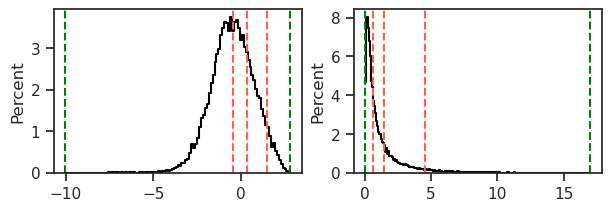

In [9]:
fig, axes = create_figure(1, 2)

sns.histplot(log_lambda, element='step', fill=False, stat='percent', label=k, color='k', ax=axes[0])
sns.histplot(np.exp(log_lambda), element='step', fill=False, stat='percent', label=k, color='k', ax=axes[1])

for i in range(len(quantiles)):
    color = 'g' if i in [0, len(quantiles) - 1] else 'tomato'
    axes[0].axvline(quantiles[i], ls='--', color=color)
    axes[1].axvline(np.exp(quantiles[i]), ls='--', color=color)

plt.show()

In [10]:
pois.rate.shape, pois.rsample().shape

(torch.Size([200, 128]), torch.Size([200, 128]))

In [ ]:
# pois = output['dist']['T_9']
# log_lambda = tonp(torch.log(pois.rate).ravel())

#   # np.arange(0, 1 + 1e-3, 0.2)
# quantiles = np.quantile(log_lambda, q=q)

In [60]:
quantiles = [0.5, 0.75, 0.95]
quantiles = [0] + quantiles + [1]
quantiles = sorted(set(quantiles))

print(quantiles)

[0, 0.5, 0.75, 0.95, 1]

In [61]:
masks = {}
for i in range(len(quantiles) - 1):
    lower = torch.quantile(pois.rate, quantiles[i])
    higher = torch.quantile(pois.rate, quantiles[i + 1])
    masks[i] = (lower < pois.rate) & (pois.rate <= higher)

print({i: m.float().mean() for i, m in masks.items()})

{
    0: tensor(0.5000, device='cuda:0'),
    1: tensor(0.2500, device='cuda:0'),
    2: tensor(0.2000, device='cuda:0'),
    3: tensor(0.0500, device='cuda:0')
}

In [62]:
from base.distributions import compute_n_exp

In [63]:
r_max = {i: pois.rate[m].max().item() for i, m in masks.items()}
n_exp = {i: compute_n_exp(r) for i, r in r_max.items()}
print(n_exp)

{0: 7, 1: 10, 2: 18, 3: 40}

In [64]:
tot = 0
for i, m in masks.items():
    tot += m.sum() * n_exp[i]

print(tot)

tensor(296953, device='cuda:0')

In [66]:
total_full = pois.rate.numel() * list(n_exp.values())[-1]
total_full

1024000

In [67]:
tot.item() / total_full

0.2899931640625

In [12]:
log_lambda.shape

(25600,)

In [18]:
torch.quantile(pois.rate, q=0.25)

tensor(0.2256, device='cuda:0', grad_fn=<SqueezeBackward4>)

In [5]:
alphas = F.softplus(self.model.alphas_base)
alphas = F.normalize(alphas, p=1.0)
alphas.mul_(self.model.cfg.seq_len)

tensor([[5.2898e-08, 9.0127e-01, 6.6399e-01, 8.7520e-01, 9.7630e-01, 1.0571e+00,
         1.1890e+00, 1.3531e+00, 1.4134e+00, 1.5706e+00]], device='cuda:0',
       grad_fn=<MulBackward0>)

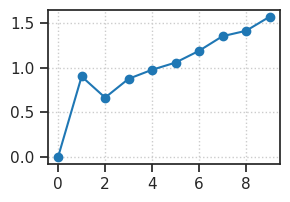

In [6]:
plt.plot(tonp(alphas.squeeze()), marker='o')
plt.grid()
plt.show()

In [7]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=100,
    n_data_batches=3,
    # active=~dead,
    full_data=True,
    # return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn'] , 'tst']
}

100%|███████████████████████████████████| 3/3 [00:11<00:00,  3.80s/it]


CPU times: user 12.4 s, sys: 109 ms, total: 12.5 s
Wall time: 12.5 s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

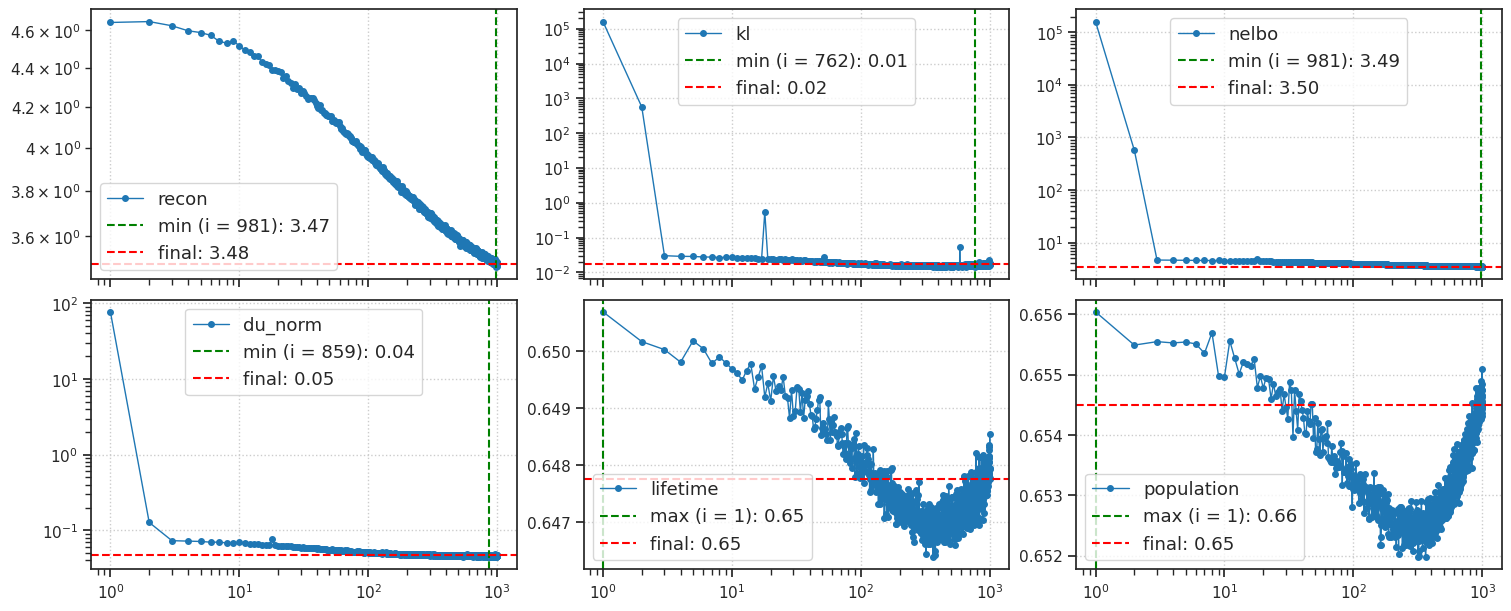

In [9]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

## Gaussian

In [ ]:
model_name = 'gaussian_MNIST_t-8_z-[2]_k-32_<conv+b|conv+b>'
fit_name = 'b200-ep500-lr(0.002)_beta(2:0x0.5)_gr(1000)_(2024_09_07,09:32)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

In [4]:
state = []
digits = []
for x, g in tqdm(iter(tr.dl_vld)):
    output = tr.model.xtract_ftr(x, return_state=True)
    state.append(output.stack('state'))
    digits.append(g)

state, digits = map(
    lambda e: tonp(torch.cat(e)),
    [state, digits],
)
state.shape, digits.shape

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 21.40it/s]


((10000, 8, 4), (10000,))

In [6]:
df = []
for t in range(tr.model.cfg.seq_len):
    df.append({
        'time': [t] * len(digits),
        'sample_i': range(len(digits)),
        'mu_0': state[:, t, 0],
        'mu_1': state[:, t, 1],
        'log_sigma_0': state[:, t, 2],
        'log_sigma_1': state[:, t, 3],
        'digits': digits,
    })
df = pd.DataFrame(merge_dicts(df))

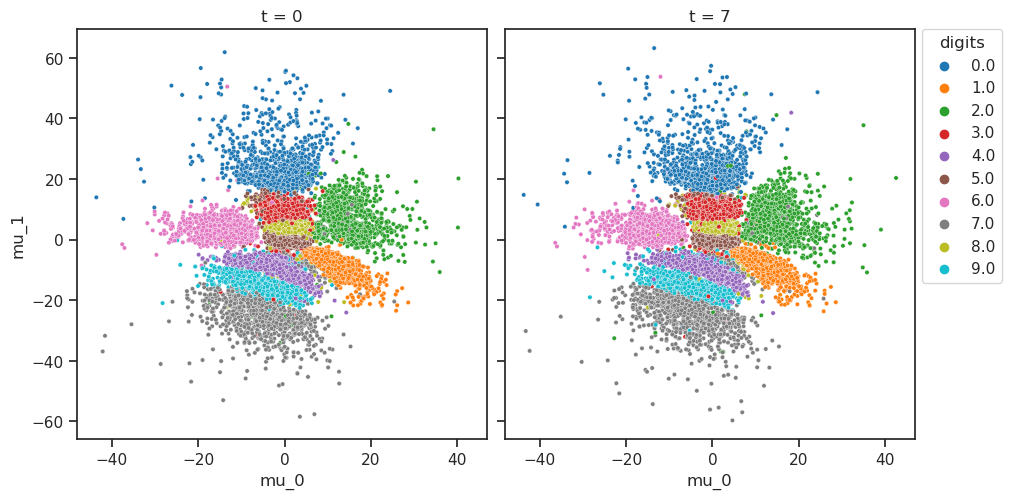

In [21]:
fig, axes = create_figure(1, 2, (10, 5), 'all', 'all')
for i, t in enumerate([0, 7]):
    ax = axes[i]
    sns.scatterplot(
        data=df.loc[df['time'] == t],
        x='mu_0',
        y='mu_1',
        hue='digits',
        palette='tab10',
        s=10,
        ax=ax,
    )
    ax.set_title(f"t = {t}")
move_legend(axes[0], None)
move_legend(axes[1], [1, 1.02])
ax_square(axes)
plt.show()

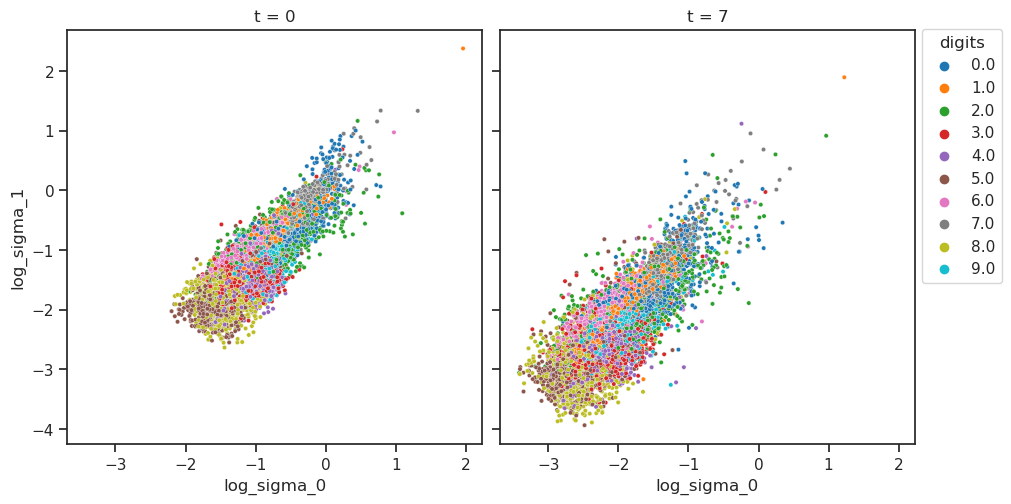

In [22]:
fig, axes = create_figure(1, 2, (10, 5), 'all', 'all')
for i, t in enumerate([0, 7]):
    ax = axes[i]
    sns.scatterplot(
        data=df.loc[df['time'] == t],
        x='log_sigma_0',
        y='log_sigma_1',
        hue='digits',
        palette='tab10',
        s=10,
        ax=ax,
    )
    ax.set_title(f"t = {t}")
move_legend(axes[0], None)
move_legend(axes[1], [1, 1.02])
ax_square(axes)
plt.show()

In [13]:
sample_i = 123
x = state[sample_i]

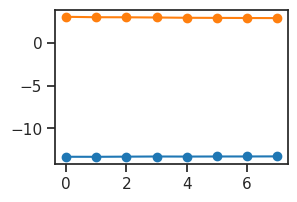

In [18]:
plt.plot(x[:, 0], marker='o')
plt.plot(x[:, 1], marker='o');

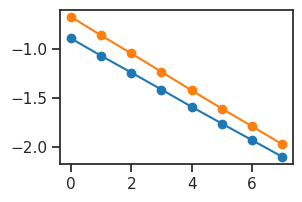

In [19]:
plt.plot(x[:, 2], marker='o')
plt.plot(x[:, 3], marker='o');

In [20]:
x[:, 1]

array([3.1016874, 3.0529828, 3.0453413, 3.0202985, 2.987599 , 2.9739113,
       2.9604445, 2.9493186], dtype=float32)

In [ ]:
"""log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()"""

In [7]:
loc = tonp(tr.model.layer.loc).ravel()
log_scale = tonp(tr.model.layer.log_scale).ravel()
bias = tonp(tr.model.layer.bias).ravel()

loc, log_scale, bias

(array([-0.0001107,  0.0277274], dtype=float32),
 array([2.2106938, 2.5960941], dtype=float32),
 array([-0.00737888,  0.00678796, -0.08695927, -0.08957231], dtype=float32))

In [8]:
dead = loc > 2
dead.sum()

0

In [9]:
%%time

kws = dict(
    seq_total=tr.model.cfg.seq_len,
    seq_batch_sz=100,
    n_data_batches=0,
    active=~dead,
    full_data=True,
    # return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn'] , 'tst']
}

  0%|                                          | 0/50 [00:00<?, ?it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

  4%|█▎                                | 2/50 [00:00<00:02, 16.47it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

  8%|██▋                               | 4/50 [00:00<00:02, 17.91it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 12%|████                              | 6/50 [00:00<00:02, 18.41it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 16%|█████▍                            | 8/50 [00:00<00:02, 18.66it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 20%|██████▌                          | 10/50 [00:00<00:02, 18.77it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 24%|███████▉                         | 12/50 [00:00<00:02, 18.50it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 28%|█████████▏                       | 14/50 [00:00<00:01, 18.71it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 32%|██████████▌                      | 16/50 [00:00<00:01, 18.85it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 36%|███████████▉                     | 18/50 [00:00<00:01, 19.00it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 40%|█████████████▏                   | 20/50 [00:01<00:01, 19.10it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 44%|██████████████▌                  | 22/50 [00:01<00:01, 19.09it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 48%|███████████████▊                 | 24/50 [00:01<00:01, 19.10it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 52%|█████████████████▏               | 26/50 [00:01<00:01, 19.09it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 56%|██████████████████▍              | 28/50 [00:01<00:01, 19.11it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 60%|███████████████████▊             | 30/50 [00:01<00:01, 19.13it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 64%|█████████████████████            | 32/50 [00:01<00:00, 19.13it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 68%|██████████████████████▍          | 34/50 [00:01<00:00, 19.14it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 72%|███████████████████████▊         | 36/50 [00:01<00:00, 19.19it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 76%|█████████████████████████        | 38/50 [00:02<00:00, 19.17it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 80%|██████████████████████████▍      | 40/50 [00:02<00:00, 19.18it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 84%|███████████████████████████▋     | 42/50 [00:02<00:00, 19.18it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 88%|█████████████████████████████    | 44/50 [00:02<00:00, 19.14it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 92%|██████████████████████████████▎  | 46/50 [00:02<00:00, 19.14it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

 96%|███████████████████████████████▋ | 48/50 [00:02<00:00, 19.15it/s]

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': False}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

{'temp': tensor(1., device='cuda:0'), 'stochastic': True, 'residual': True}

100%|█████████████████████████████████| 50/50 [00:02<00:00, 18.97it/s]


CPU times: user 2.77 s, sys: 111 ms, total: 2.88 s
Wall time: 2.84 s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

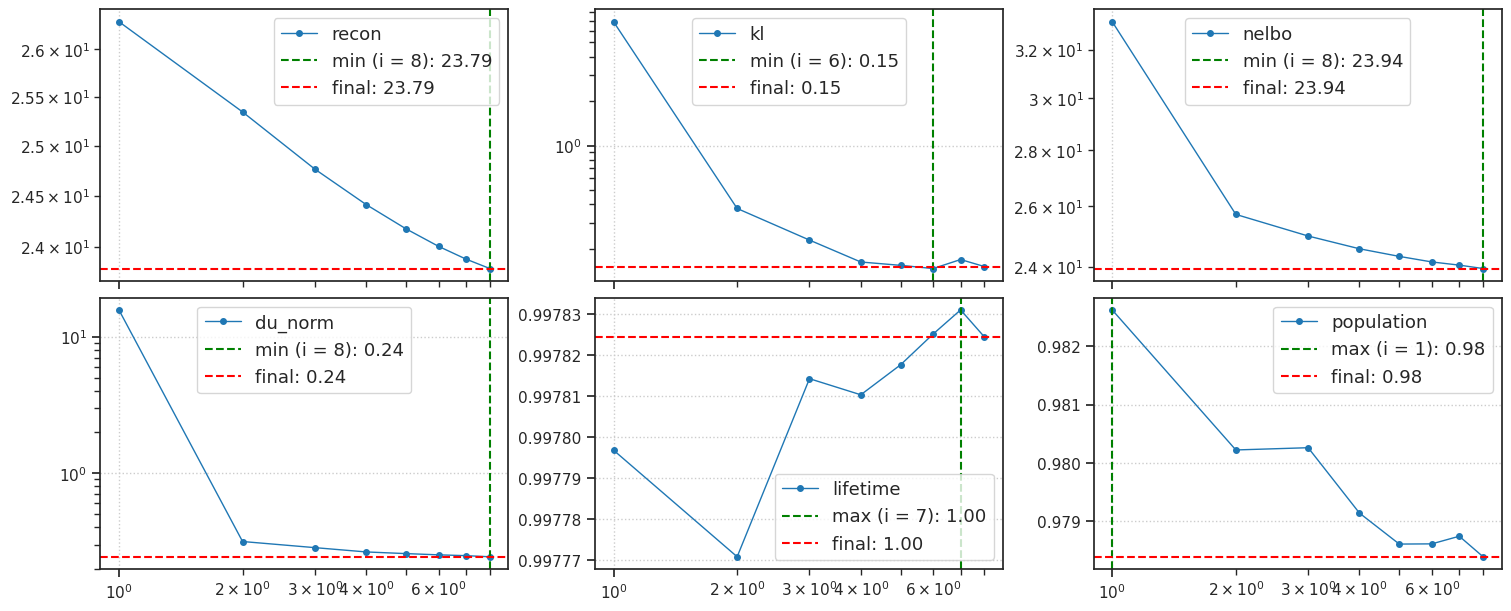

In [7]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

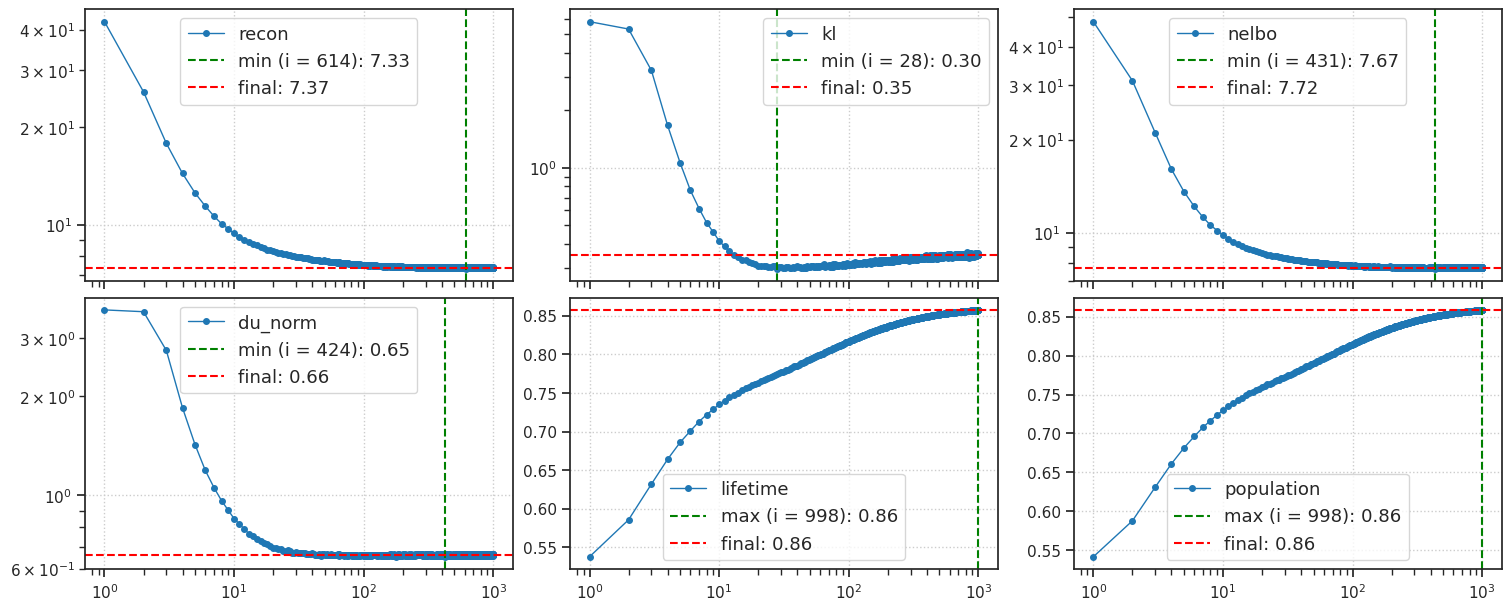

In [16]:
## was:  < jacob | mlp+b > (gold standard)

In [8]:
state = results['vld']['state_final']
digits = results['vld']['g'].astype(int)

df2p = {
    'mu_0': state[:, 0],
    'mu_1': state[:, 1],
    'log_sigma_0': state[:, 2],
    'log_sigma_1': state[:, 3],
    'digits': digits,
}
df2p = pd.DataFrame(df2p)

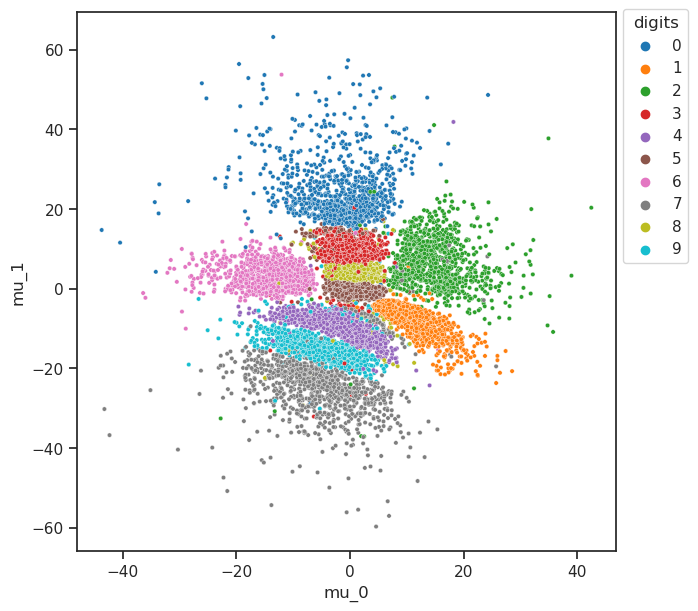

In [9]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=df2p,
    x='mu_0',
    y='mu_1',
    hue='digits',
    palette='tab10',
    s=10,
    ax=ax,
)
move_legend(ax, [1, 1.02])
ax_square(ax)
plt.show()

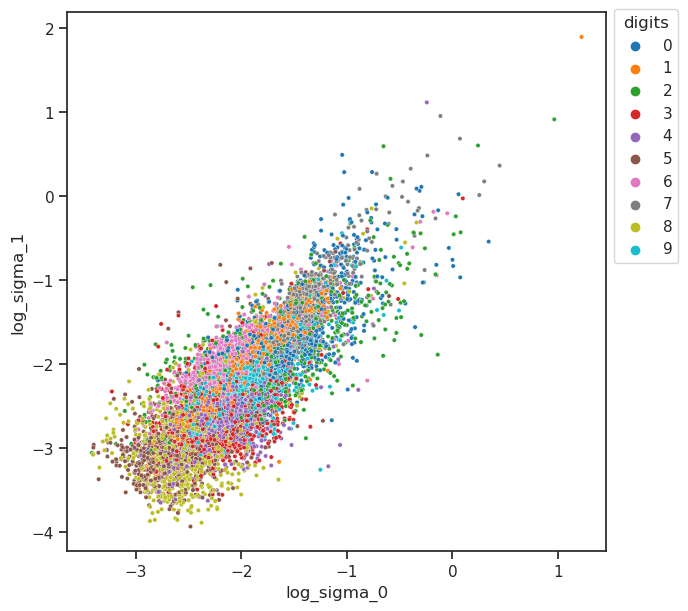

In [10]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=df2p,
    x='log_sigma_0',
    y='log_sigma_1',
    hue='digits',
    palette='tab10',
    s=10,
    ax=ax,
)
move_legend(ax, [1, 1.02])
ax_square(ax)
plt.show()

### Generate

In [18]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

output = tr.model.generate(pred, seq=range(300))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['ff', 'dist', 'samples', 'recon', 'loss_kl', 'loss_recon']

In [19]:
shape = (tr.model.cfg.input_sz, tr.model.cfg.input_sz)

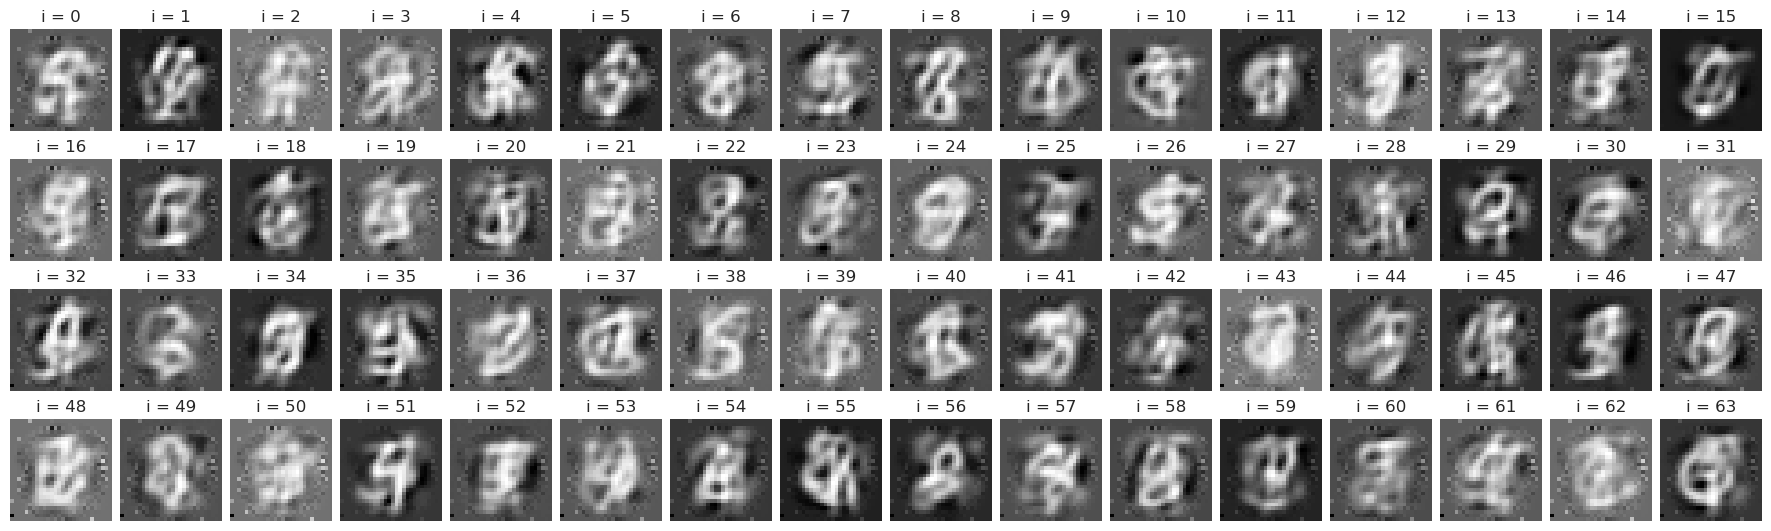

In [20]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')
for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    x2p = tonp(pred[sample_i].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")
trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [21]:
sample_i = 30

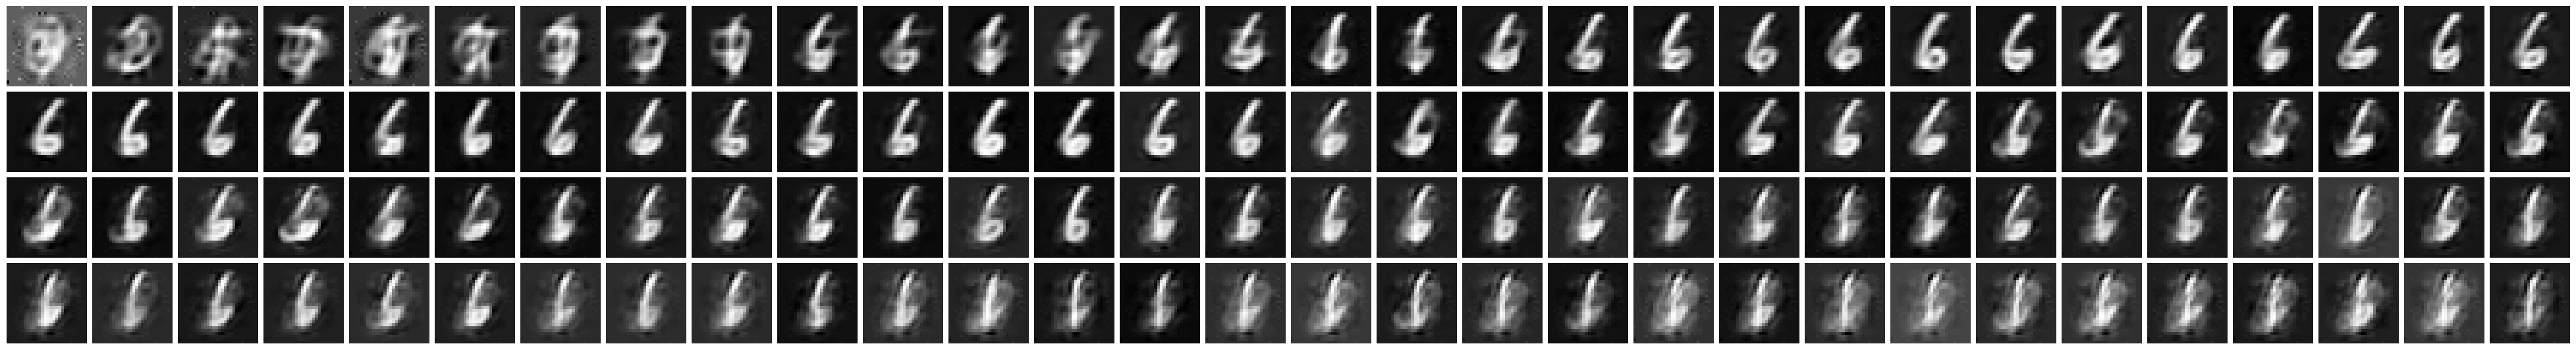

In [22]:
nrows, ncols = 4, 30
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    x2p = tonp(output['recon'][sample_i, idx].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes)

In [25]:
order = np.argsort(desc_len)[::-1]

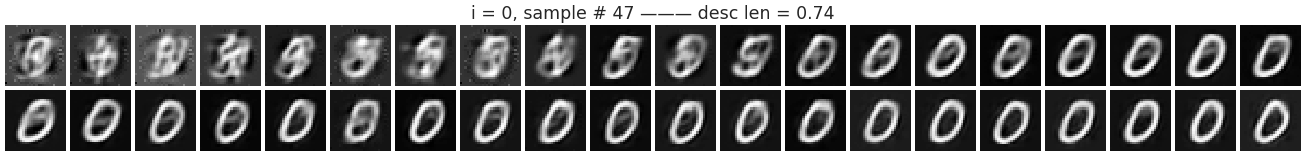

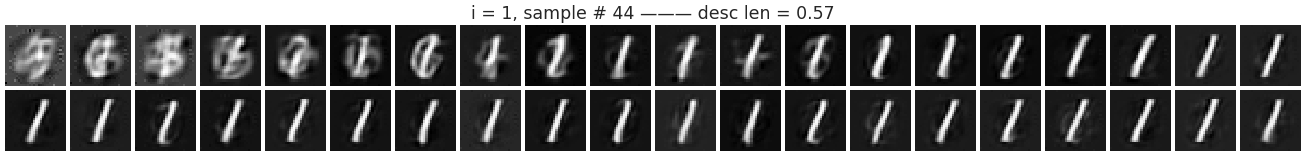

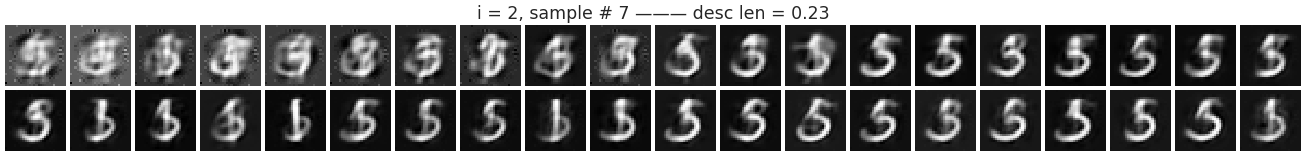

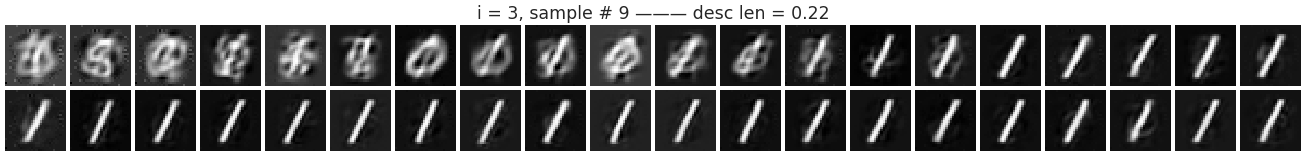

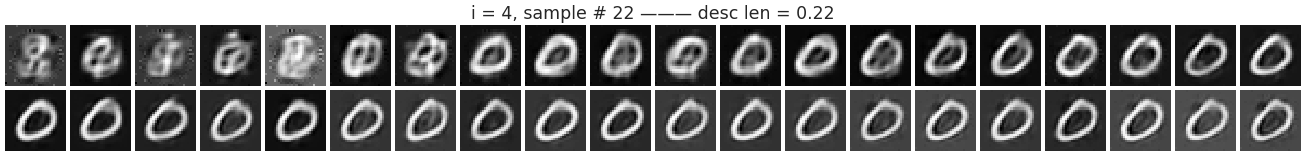

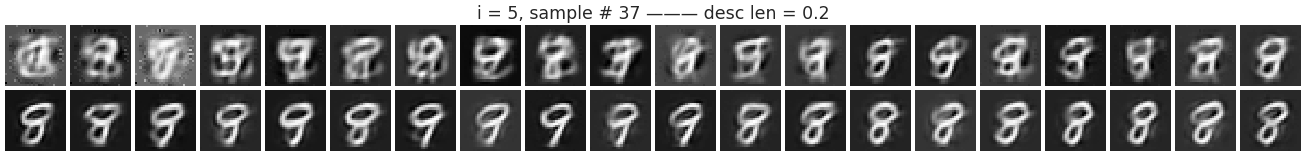

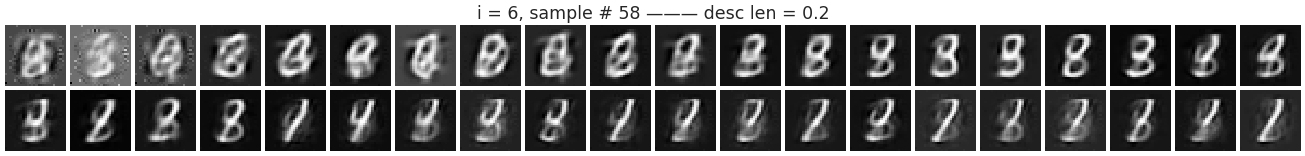

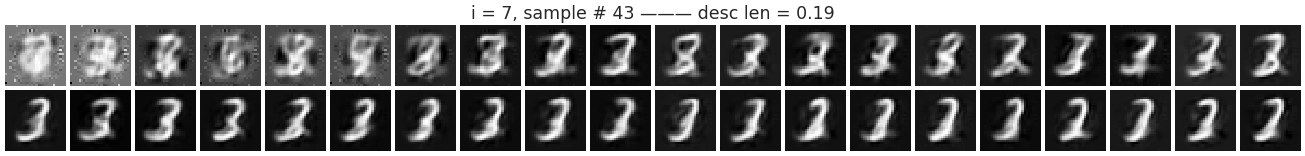

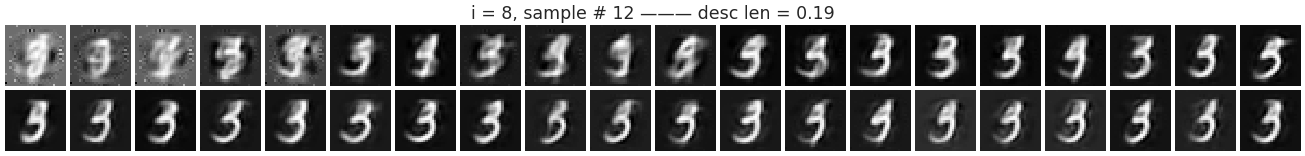

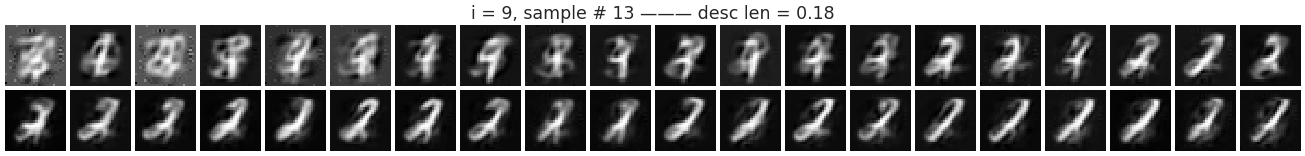

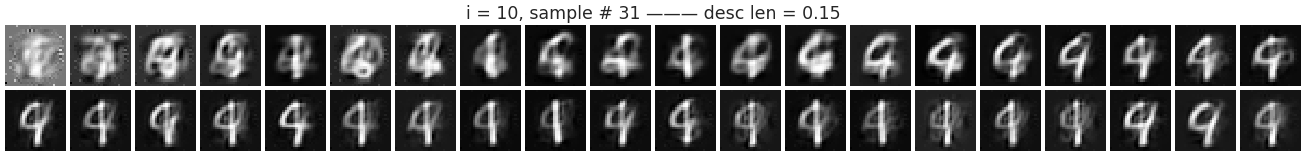

In [26]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 2, 20
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=50)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i].reshape(shape))
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(output['recon'][sample_i, idx - 1].reshape(28, 28))
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()

## Gaussian

In [3]:
which = 'mlp'

paste here:


In [10]:
if which == 'conv':
    model_name = ''
    fit_name = ''

elif which == 'mlp':
    model_name = 'gaussian_MNIST_t-10_z-[128]_k-32_<jacob|mlp+b>'
    fit_name = 'b200-ep500-lr(0.002)_beta(5:0x0.5)_gr(1000)_(2024_09_06,20:37)'

elif which == 'lin':
    model_name = ''
    fit_name = ''

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

500

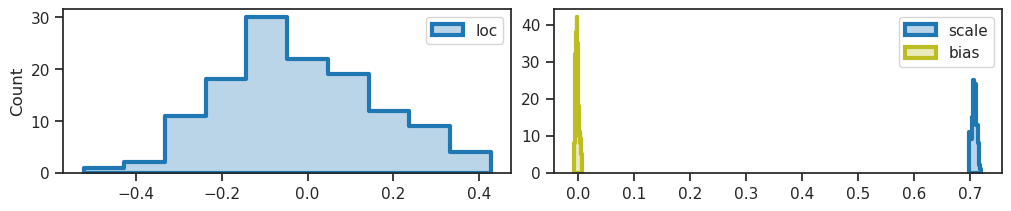

In [9]:
loc = tonp(tr.model.layer.loc).ravel()
log_scale = tonp(tr.model.layer.log_scale).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(loc, color='C0', element='step', label='loc', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_scale), color='C0', element='step', label='scale', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [6]:
dead = loc > 2
dead.sum()

0

In [7]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=3,
    active=~dead,
    # full_data=True,
    # return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn'] , 'tst']
}

100%|███████████████████████████████████| 3/3 [00:08<00:00,  2.96s/it]


CPU times: user 8.22 s, sys: 460 ms, total: 8.68 s
Wall time: 9.77 s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

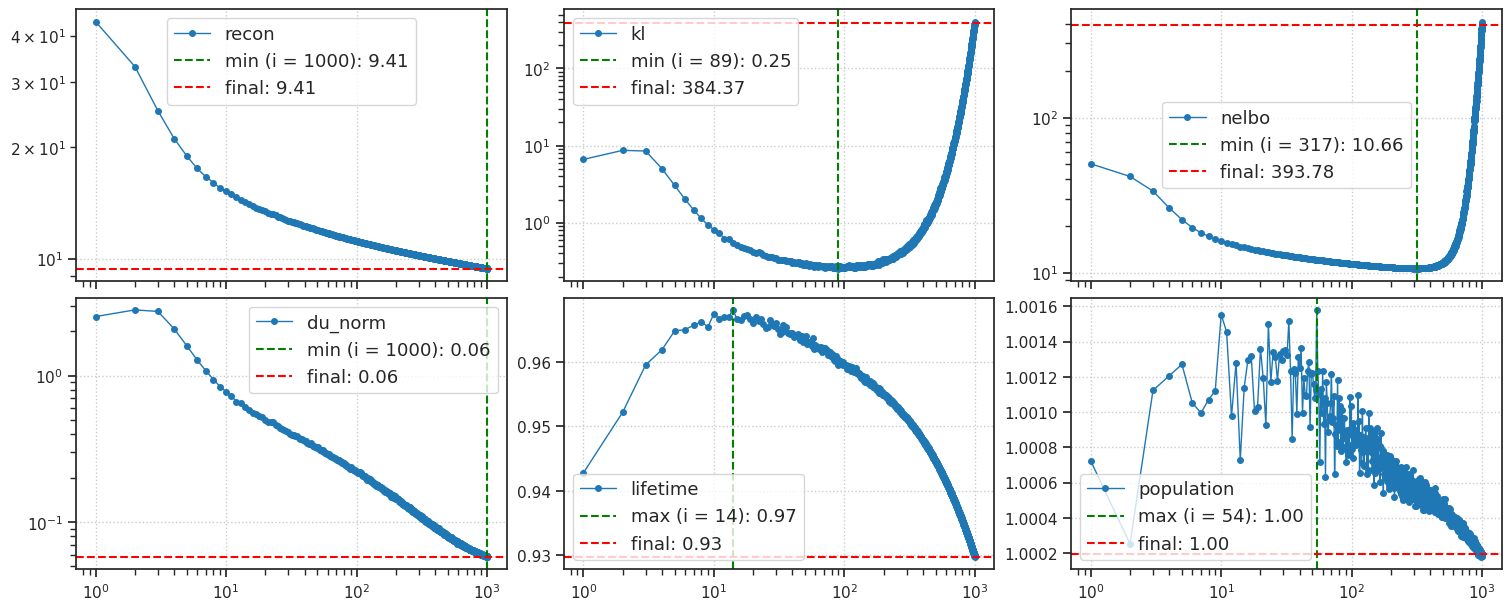

In [8]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

### Generate

In [5]:
n_samples = 64
tr.model.reset_state(n_samples)
pred = tr.model.layer.generate(temp=0.0)[-1]

In [6]:
output = tr.model.generate(pred, seq=range(300))

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 128]], which is output 0 of ExpBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [16]:
tr.model.cfg.jac_type = 'vmap'

In [17]:
output = tr.model.generate(tr.model.pred, seq=range(300))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x256 and 128x234)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 128]], which is output 0 of ExpBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
output = output.stack()

In [10]:
with torch.no_grad():
    n_samples = 64
    tr.model.reset_state(n_samples)
    tr.model.update_pred(temp=0.0)
    pred = tr.model.pred
    
    output = tr.model.generate(pred, seq=range(300))
    output = output.stack()
    
    loss_kl = tonp(torch.sum(output['loss_kl'], -1))
    u = tr.model.log_rate.expand(n_samples, -1)
    desc_len = tr.model.layer.loss_kl(u=u)
    desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 128]], which is output 0 of ExpBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [11]:
shape = (tr.model.cfg.input_sz, tr.model.cfg.input_sz)

In [ ]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')
for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    x2p = tonp(pred[sample_i].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")
trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [13]:
sample_i = 30

In [ ]:
nrows, ncols = 4, 30
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    x2p = tonp(output['recon'][sample_i, idx].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes)

In [ ]:
order = np.argsort(desc_len)[::-1]

In [ ]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 2, 20
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=50)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i].reshape(shape))
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(output['recon'][sample_i, idx - 1].reshape(28, 28))
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()

## Poisson MLP

Gold standard

In [3]:
which = 'mlp'

paste here:


In [4]:
if which == 'conv':
    model_name = 'poisson_uniform_c(-2)_MNIST_t-16_z-[128]_k-32_<jacob|conv+b>'
    fit_name = 'mc_b256-ep600-lr(0.002)_beta(4:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_06,00:50)'

elif which == 'mlp':
    model_name = 'poisson_uniform_c(-2)_MNIST_t-10_z-[128]_k-32_<jacob|mlp+b>'
    fit_name = 'FINAL_b200-ep500-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_06,19:15)'

elif which == 'lin':
    model_name = ''
    fit_name = ''

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

500

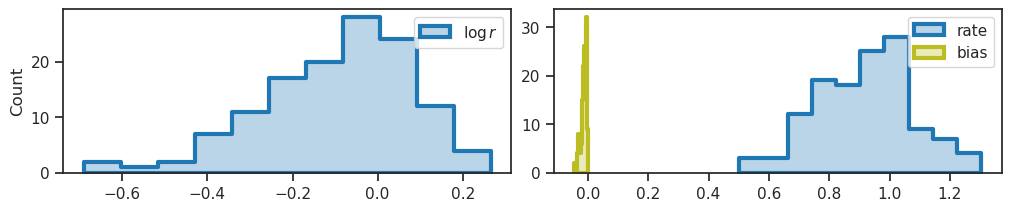

In [5]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [6]:
dead = log_rate > 2
dead.sum()

0

In [7]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=0,
    active=~dead,
    # full_data=True,
    # return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld'] # 'trn'] , 'tst']
}

100%|█████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it]


CPU times: user 1min 26s, sys: 2.19 s, total: 1min 28s
Wall time: 1min 28s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

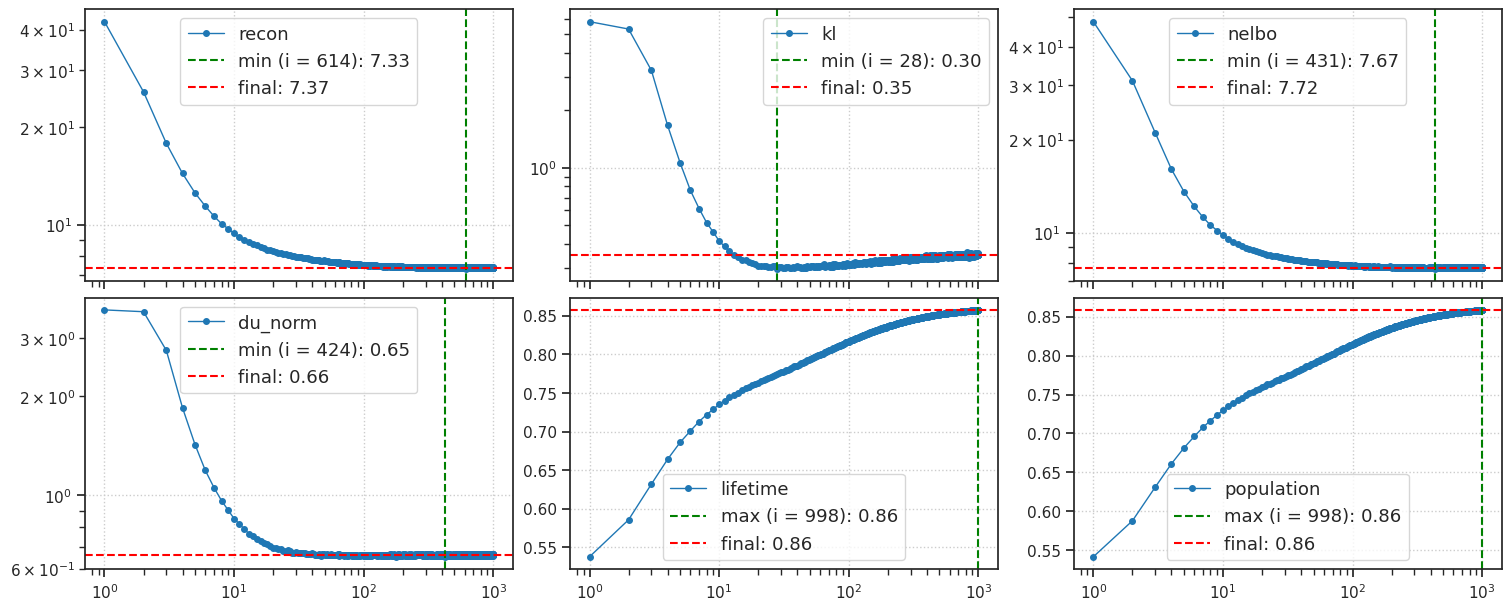

In [8]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

In [35]:
kl_temporal = []
kl_one_shot = []

with torch.no_grad():
    for x, *_ in tqdm(iter(tr.dl_vld)):
        output = tr.model.xtract_ftr(x)
        output = output.stack()
        
        kl_temporal.append(torch.sum(output['loss_kl'], dim=2))
        
        prior = tr.model.layer.log_rate.expand((len(x), -1))
        kl_one_shot.append(torch.sum(tr.model.layer.loss_kl(
            u=prior, du=tr.model.state - prior), dim=1))

    kl_temporal = torch.cat(kl_temporal)
    kl_one_shot = torch.cat(kl_one_shot)

kl_temporal.shape, kl_one_shot.shape

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 80.38it/s]


(torch.Size([10000, 10]), torch.Size([10000]))

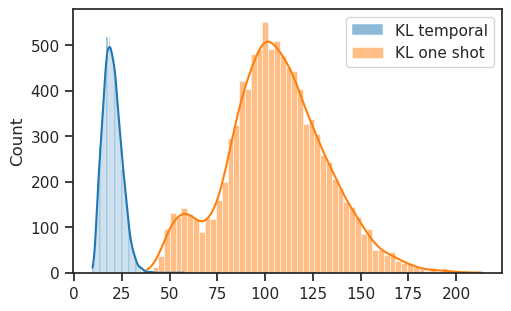

In [36]:
fig, ax = create_figure(1, 1, (5, 3))
sns.histplot(tonp(kl_temporal.sum(1)), kde=True, label='KL temporal')
sns.histplot(tonp(kl_one_shot), kde=True, label='KL one shot')
ax.legend()
plt.show()

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

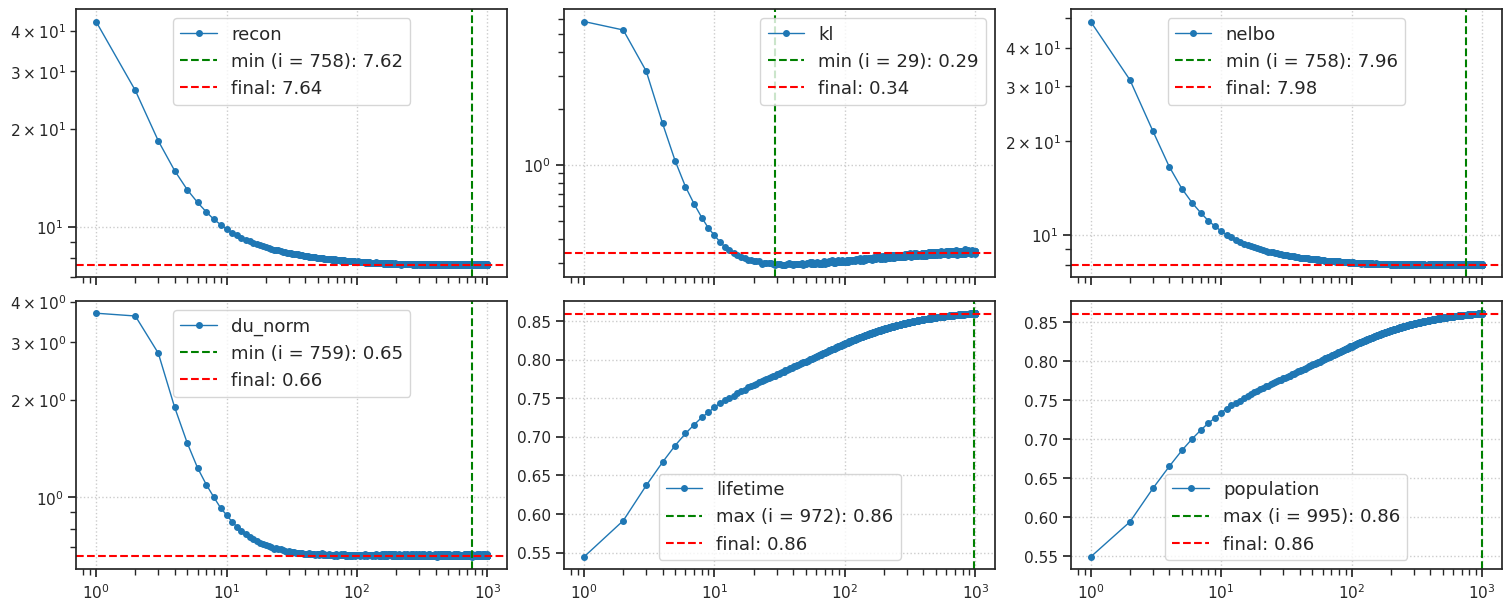

In [9]:
## Was with one sample drawn (instead of two: prior + post) 

### Generate

In [18]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

output = tr.model.generate(pred, seq=range(300))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['ff', 'dist', 'samples', 'recon', 'loss_kl', 'loss_recon']

In [19]:
shape = (tr.model.cfg.input_sz, tr.model.cfg.input_sz)

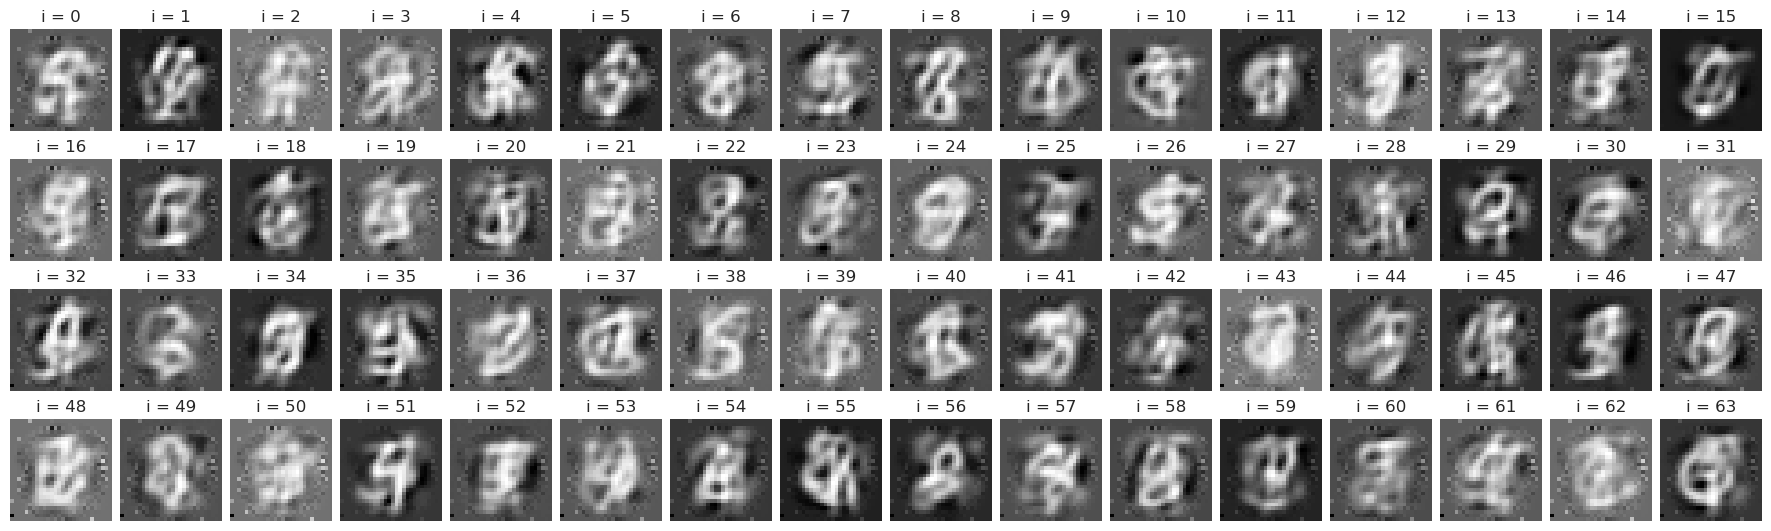

In [20]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')
for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    x2p = tonp(pred[sample_i].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")
trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [21]:
sample_i = 30

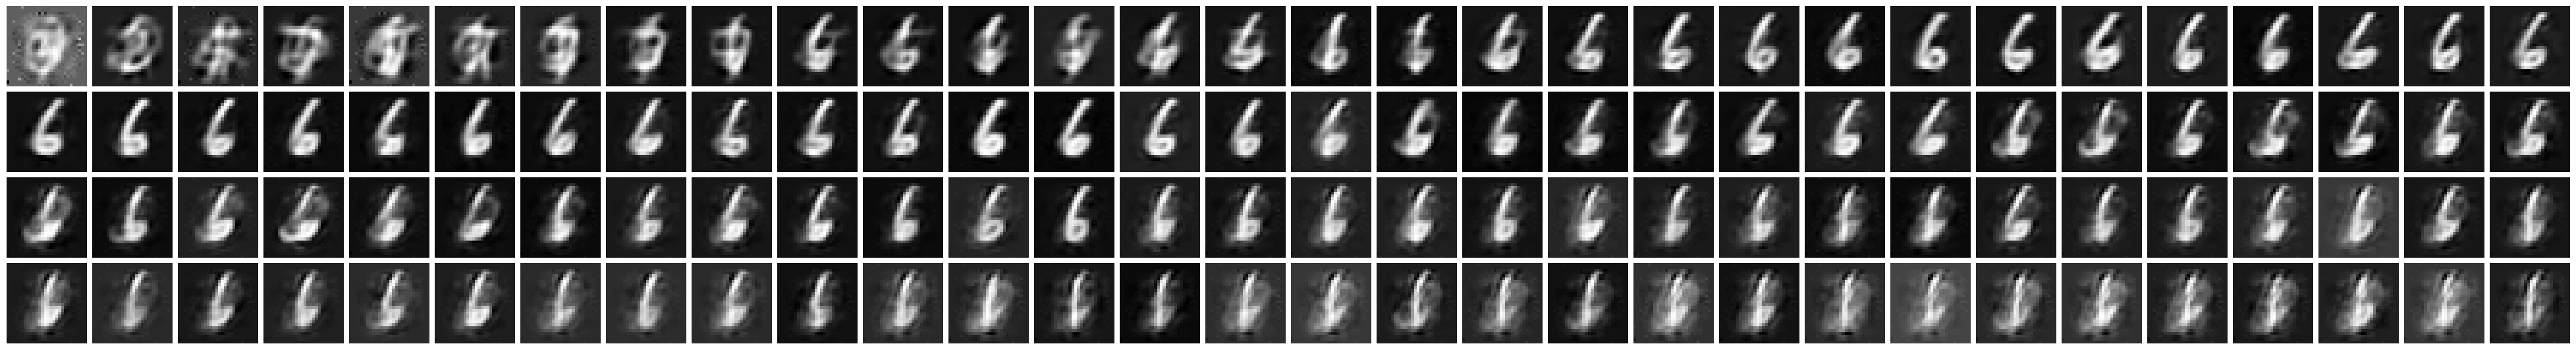

In [22]:
nrows, ncols = 4, 30
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    x2p = tonp(output['recon'][sample_i, idx].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes)

In [25]:
order = np.argsort(desc_len)[::-1]

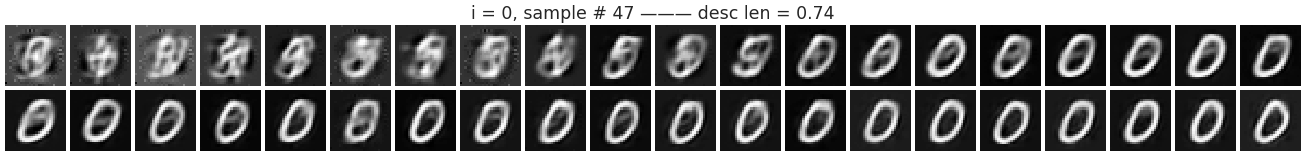

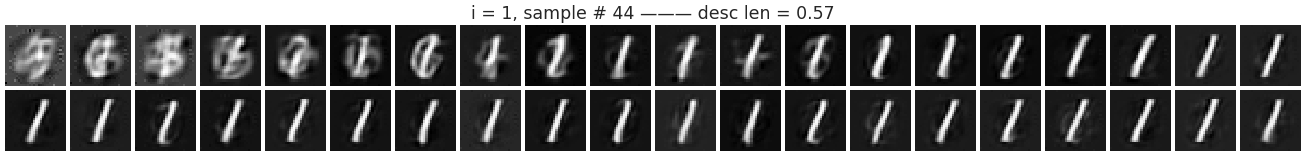

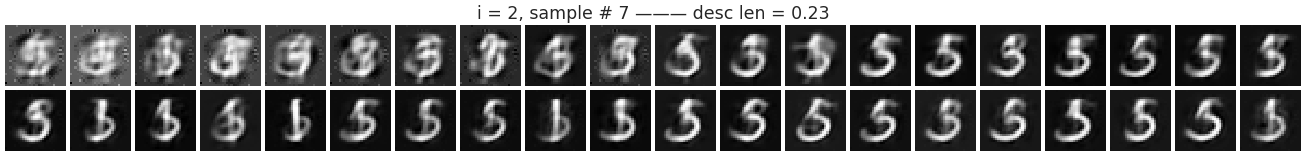

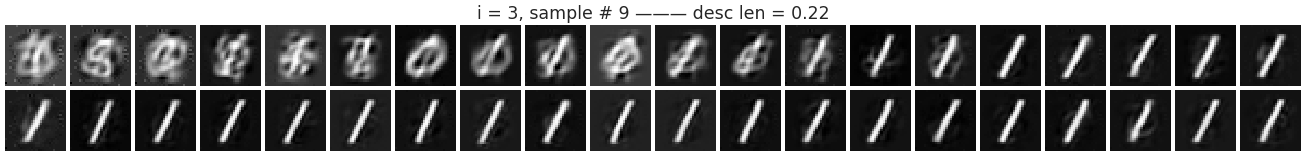

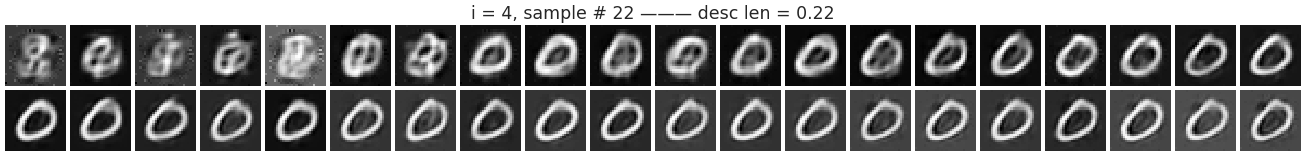

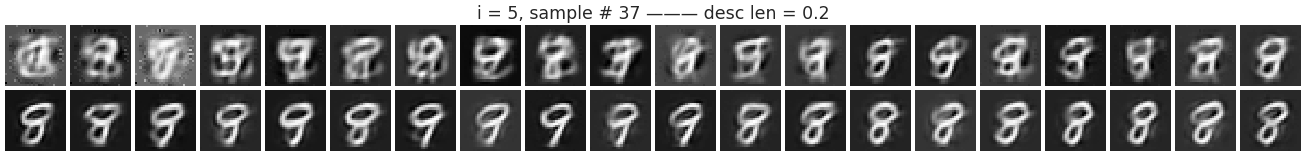

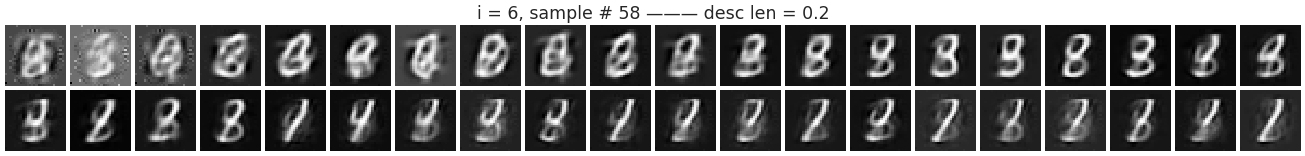

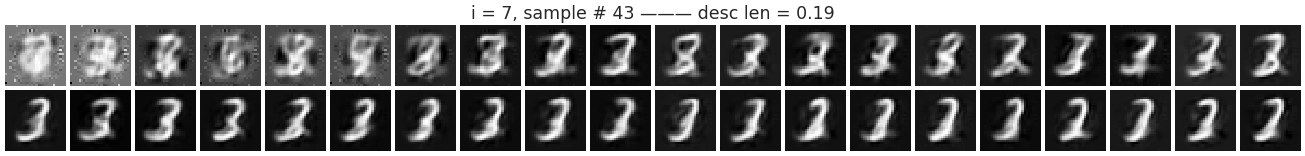

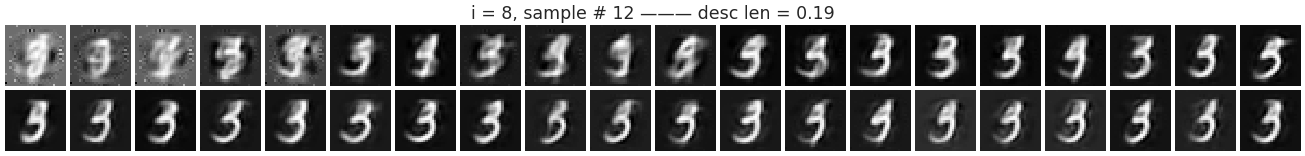

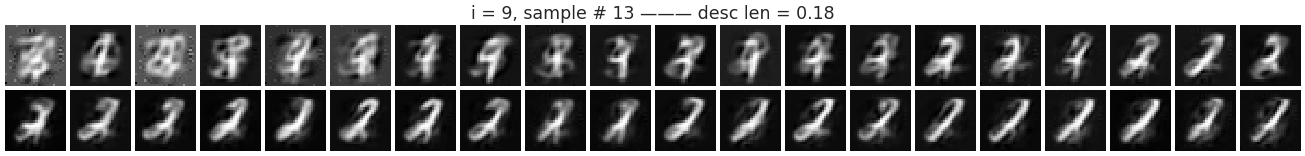

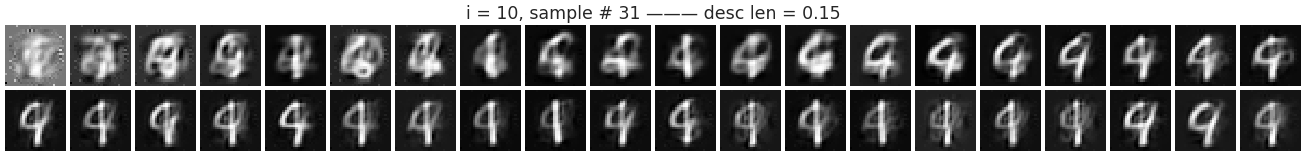

In [26]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 2, 20
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=50)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i].reshape(shape))
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(output['recon'][sample_i, idx - 1].reshape(28, 28))
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()